## Mega Caso de Estudio 

Realizaremos un modelo híbrido de aprendizaje automatizado (*Red Neuronal Artificial* (**ANN**) + **SOM**). Para ello usaremos el mismo dataset de las tarjetas de crédito usado anteriormente. 

Para ello pasaremos del modelo *Deep Learning* **supervisado** al **no-supervisado**.

### Pasos para entrenar un SOM:

- <span style='color:#288c17'> <b>PASO 1:</span> Empezamos con un dataset compuesto de *n_features* variables independientes.

- <span style='color:#288c17'> <b>PASO 2:</span> Preparamos una parrilla compuesta de nodos, cada uno con un vector de pesos de *n_features* elementos.

- <span style='color:#288c17'> <b>PASO 3:</span> Aleatoriamente inicializamos valores del vector de pesos a números pequeños cercanos a $0$ (pero no $0$).

- <span style='color:#288c17'> <b>PASO 4:</span> Seleccionar una observación aleatoria del dataser.

- <span style='color:#288c17'> <b>PASO 5:</span> Calcular la distancia Euclídea desde dicho puntos a las diferentes neuronas de la red.

- <span style='color:#288c17'> <b>PASO 6:</span> Seleccionar la neurona con la menor distancia al punto. Dicha neurona es el nodo ganador.

- <span style='color:#288c17'> <b>PASO 7:</span> Actualizar lso epsos del nodo ganador para moverlo más cerca dle punto.

- <span style='color:#288c17'> <b>PASO 8:</span> Utilizar una función Gaussiana al vecindario del punto de medie el nodo ganador y actualizar los pesos de los vecinos para moverlos más cerca del punto. El radio de los vecinos afectados es la desviación típica de la Gaussiana.

- <span style='color:#288c17'> <b>PASO 9:</span> Repetir los pasos <span style='color:#288c17'> <b>1</span> a <span style='color:#288c17'> <b>5</span> y actualizar los pesos después de cada observación (*Reinforcement Learning*) o después de un conjunto de observaciones (*Batch Learning*), hasta que la red neuronal converja en un punto donde los vecindarios no cambien.

# Parte 1 - Identificar los fraudes potenciales con un SOM

In [11]:
# Importar las librerías
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
# Importar el dataset
dataset = pd.read_csv("Credit_Card_Applications.csv")
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [13]:
# Escalado de características
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

In [14]:
# Entrenar el SOM
from minisom import MiniSom
som = MiniSom(x = 10, y = 10, input_len = 15, sigma = 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

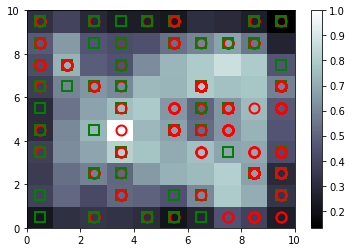

In [15]:
# Visualizar los resultados
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0]+0.5, w[1]+0.5,
         markers[y[i]], markeredgecolor = colors[y[i]], markerfacecolor = 'None', 
         markersize = 10, markeredgewidth = 2)
show()

In [29]:
# Encontrar los fraudes
mappings = som.win_map(X)
frauds = np.concatenate( (mappings[(6,1)], mappings[(7,8)]), axis = 0 )
frauds = sc.inverse_transform(frauds)

# Parte 2 - Trasladar el modelo de Deep Learning de no supervisado a supervisado

In [19]:
# Crear la matriz de características
customers = dataset.iloc[:, 1:-1].values

In [20]:
# Crear la variable dependiente
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
    if dataset.iloc[i, 0] in frauds:
        is_fraud[i] = 1

In [21]:
# Escalado de variables
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
customers = sc_X.fit_transform(customers)

# Parte 3 - Construir la RNA

In [22]:
# Importar Keras y librerías adicionales
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [23]:
# Inicializar la RNA
classifier = Sequential()

In [24]:

# Añadir las capas de entrada y primera capa oculta
classifier.add(Dense(units = 2, kernel_initializer = "uniform",  activation = "relu", input_dim = 14))


# Añadir la capa de salida
classifier.add(Dense(units = 1, kernel_initializer = "uniform",  activation = "sigmoid"))

In [25]:
# Compilar la RNA
classifier.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])


In [26]:
# Ajustamos la RNA al Conjunto de Entrenamiento
classifier.fit(customers, is_fraud,  batch_size = 1, epochs = 2)

Epoch 1/2
690/690 [==============================] - 2s 2ms/step - loss: 0.4584 - accuracy: 0.9812
Epoch 2/2
690/690 [==============================] - 1s 907us/step - loss: 0.1393 - accuracy: 0.9826


In [27]:
# Predicción de los resultados de fraude
y_pred  = classifier.predict(customers)
y_pred = np.concatenate((dataset.iloc[:,0:1].values, y_pred), axis = 1)
y_pred = y_pred[y_pred[:,1].argsort()]
